In [199]:
# Import libraries for data manipulation
import pandas as pd
import numpy as np

# Import libraries for data visualization
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for building linear regression model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge

# Import library for preparing data
from sklearn.model_selection import train_test_split

# Import library for data preprocessing

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression


# Import libraries for scoring models
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

### Overall Process:  Functionalize these steps
- #### 1. Import, X-y separation, train_test_split
- #### 2. create 6 datasets
- #### 3. impute, encoding, separate cat/num
- #### 4. build models
- #### 5. score models

#### But first some EDA

In [110]:
data = pd.read_csv("auto_1993_adj.csv")
df = data.copy()

In [111]:
df.head()

,ID,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
0,1,307.0,8,130.0,3504,12.0,70,1,18.0
1,2,350.0,8,165.0,3693,11.5,70,1,15.0
2,3,318.0,8,150.0,3436,11.0,70,1,18.0
3,4,304.0,8,150.0,3433,12.0,70,1,16.0
4,5,302.0,8,140.0,3449,10.5,70,1,17.0


In [116]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,398.0,199.500000,115.036951,1.0,100.250,199.5,298.750,398.0
displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
horsepower,392.0,104.469388,38.491160,46.0,75.000,93.5,126.000,230.0
weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
model_year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6


In [117]:
# df.info()

In [118]:
# We will drop "ID" as it is unlikely to contribute to our analysis
#create dataframe of features only
features = df.drop(["ID","mpg"], axis=1)
#create dataframe of target only
target = df["mpg"]

#### Let's look at the distribution of the data.

array([[<Axes: title={'center': 'ID'}>,
        <Axes: title={'center': 'displacement'}>,
        <Axes: title={'center': 'cylinders'}>],
       [<Axes: title={'center': 'horsepower'}>,
        <Axes: title={'center': 'weight'}>,
        <Axes: title={'center': 'acceleration'}>],
       [<Axes: title={'center': 'model_year'}>,
        <Axes: title={'center': 'origin'}>,
        <Axes: title={'center': 'mpg'}>]], dtype=object)

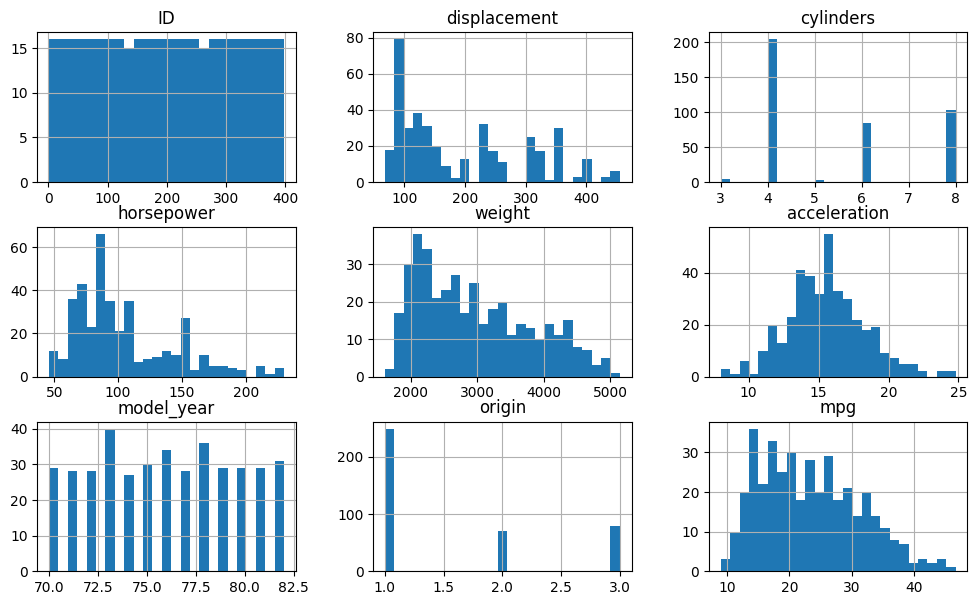

In [119]:
df.hist(bins=25, figsize = (12,7))

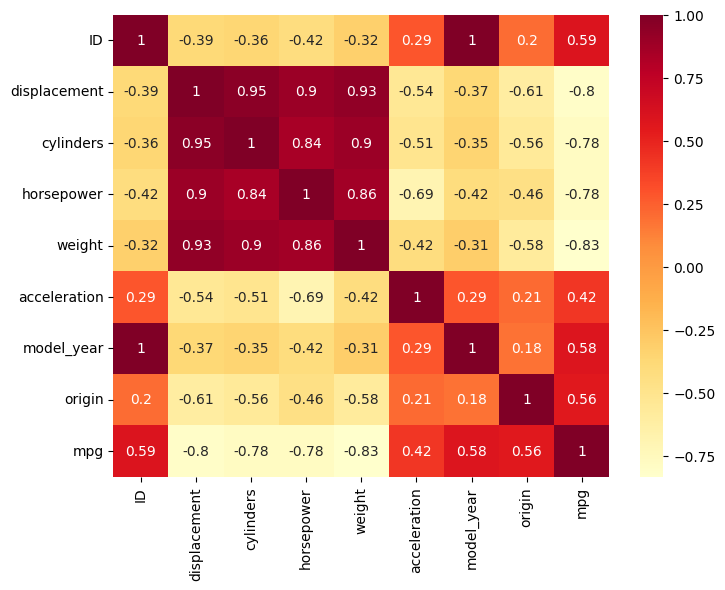

In [120]:
corr_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="YlOrRd")
plt.show()

In [130]:
#Assign X & y:
X = data.copy()
X = X.dropna(axis=0)
y = X.pop("mpg")

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [149]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


mi_scores = make_mi_scores(X, y)
mi_scores

weight          0.786053
displacement    0.779447
horsepower      0.740301
cylinders       0.604470
ID              0.441498
model_year      0.357739
origin          0.252566
acceleration    0.200152
Name: MI Scores, dtype: float64

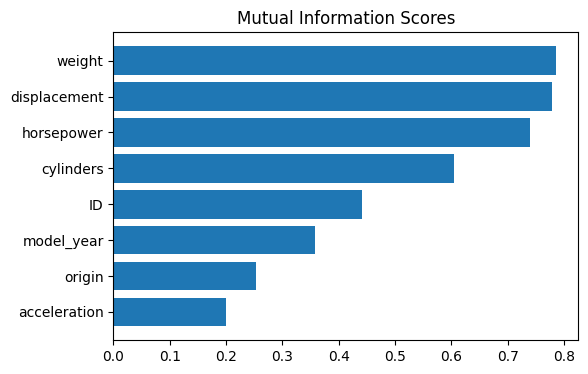

In [151]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(6, 4))
plot_mi_scores(mi_scores)

In [152]:
# New features
features["P_to_W"] = features["horsepower"] / features["weight"]
features["D_to_W"] = features["displacement"] / features["weight"]
features["cyl_vol"] = features["displacement"] / features["cylinders"]
features["SIZE"] = features["displacement"] + features["weight"]
features["Performance"] = features["horsepower"] + features["acceleration"]

In [175]:
# 6 Distinct Feature Sets
# # Set 1
df1 = features[
    [
        "displacement",
        "cylinders",
        "horsepower",
        "weight",
        "acceleration",
        "model_year",
        "origin",
    ]
]
df2 = features[["displacement", "horsepower", "weight", "acceleration"]]
df3 = features[["cylinders", "origin"]]
df4 = features[["model_year", "weight", "cylinders"]]
df5 = features[["model_year", "weight", "cyl_vol"]]
df6 = features[["displacement", "horsepower"]]
df7 = features[["Performance"]]

In [260]:
def auto_regres(data, model):
    # Separate features and target
    X = data
    global target
    y = target

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=16
    )

    # Separate CAT & NUM features
    cat_cols = ["cylinders", "origin"]
    num_cols = [
        "displacement",
        "horsepower",
        "weight",
        "acceleration",
        "model_year",
        "P_to_W",
        "D_to_W",
        "cyl_vol",
        "SIZE",
        "Performance",
    ]
    cat_cols = [col for col in data.columns if col in cat_cols]
    num_cols = [col for col in data.columns if col in num_cols]

    # Transform NUM Data
    numerical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer()),
            ("scale", MinMaxScaler()),
        ]
    )

    # Transform CAT Data
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, num_cols),
            ("cat", categorical_transformer, cat_cols),
        ]
    )

    # Preprocess data then create model
    mod_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

    # Preprocess training data, fit model
    # X_train_transformed = mod_pipeline.named_steps["preprocessor"].fit_transform(X_train)     #use this to extract transformed values
    mod_pipeline.fit(X_train, y_train)
    # print(X_train_transformed)                                                                #print transformed values
    # Get predictions for training data
    preds = mod_pipeline.predict(X_test)
    cv_scores = np.mean(
        -1
        * cross_val_score(mod_pipeline, X, y, cv=10, scoring="neg_mean_squared_error")
    )

    # print("MAE scores:\n", scores)

    return (
        mean_squared_error(y_test, preds),
        cv_scores, 
        r2_score(y_test, preds)
    )

In [201]:
# Define models
knn = KNeighborsRegressor()
svr = SVR()
ridge = Ridge()

In [261]:
#KNN results:  mean squared, R_2, CV mean squared
print(auto_regres(df1, knn))
# print(auto_regres(df2, knn))
# print(auto_regres(df3, knn))
# print(auto_regres(df4, knn))
# print(auto_regres(df5, knn))
# print(auto_regres(df6, knn))

[[0.75452196 0.91847826 0.84961329 ... 1.         0.         0.        ]
 [0.05684755 0.1576087  0.13148095 ... 0.         1.         0.        ]
 [0.18604651 0.17391304 0.27012317 ... 1.         0.         0.        ]
 ...
 [0.64599483 0.56521739 0.50128903 ... 1.         0.         0.        ]
 [0.07751938 0.20108696 0.12202807 ... 1.         0.         0.        ]
 [0.42377261 0.29347826 0.36236036 ... 1.         0.         0.        ]]
(10.877836, 10.21309969230769, 0.8393997647712921)


In [228]:
knn_list = [
    auto_regres(df1, knn),
    auto_regres(df2, knn),
    auto_regres(df3, knn),
    auto_regres(df4, knn),
    auto_regres(df5, knn),
    auto_regres(df6, knn),
]
svr_list = [
    auto_regres(df1, svr),
    auto_regres(df2, svr),
    auto_regres(df3, svr),
    auto_regres(df4, svr),
    auto_regres(df5, svr),
    auto_regres(df6, svr)
]

ridge_list = [
    auto_regres(df1, ridge),
    auto_regres(df2, ridge),
    auto_regres(df3, ridge),
    auto_regres(df4, ridge),
    auto_regres(df5, ridge),
    auto_regres(df6, ridge),
]


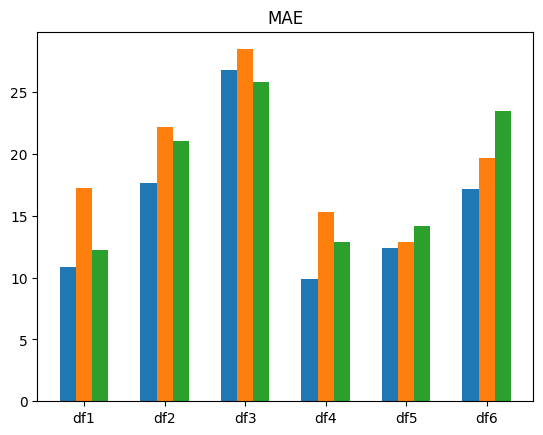

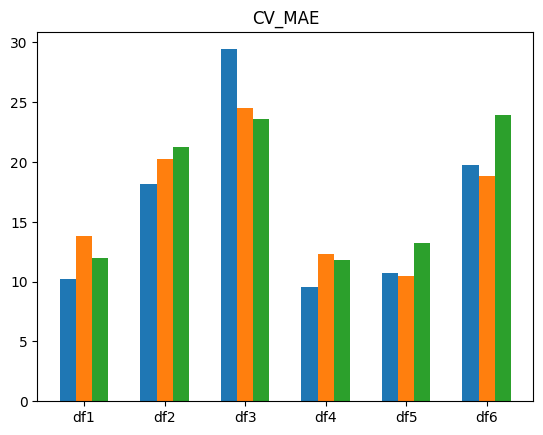

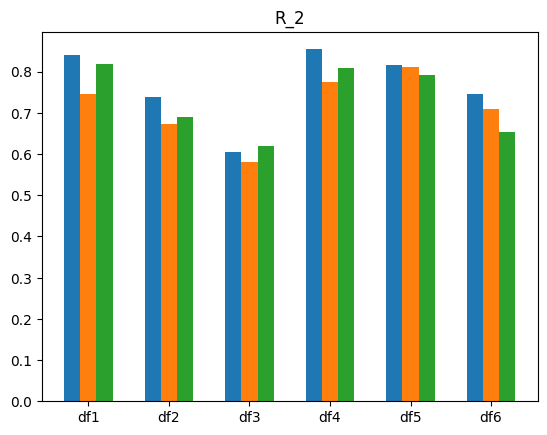

In [235]:
import numpy as np
import matplotlib.pyplot as plt

for i in ["MAE","CV_MAE","R_2"]:
    df_list = ["df1", "df2", "df3", "df4", "df5", "df6"]
    x = np.arange(len(df_list))
    plt.bar(
        x - 0.2,
        height=df_knn[i],
        label="KNN",
        width=0.2,
        align="center",
    )
    plt.bar(
        x,
        height=df_svr[i],
        label="SVR",
        width=0.2,
        align="center",
    )
    plt.bar(
        x + 0.2,
        height=df_ridge[i],
        label="Ridge",
        width=0.2,
        align="center",
    )
    plt.title(i)
    plt.xticks(x, df_list)
    plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3)

df1.bar(ax=axes[0, 0])
df2.plot(ax=axes[0, 1])
...

AttributeError: 'DataFrame' object has no attribute 'bar'

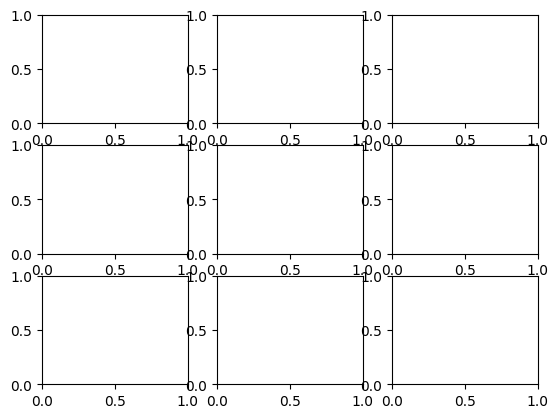

In [257]:
# define number of rows and columns for subplots
nrow = 3
ncol = 3

# make a list of all dataframes
df_list = [
    df_knn[["MAE"]],
    df_knn[["CV_MAE"]],
    df_knn[["R_2"]],
    df_svr[["MAE"]],
    df_svr[["CV_MAE"]],
    df_svr[["R_2"]],
    df_ridge[["MAE"]],
    df_ridge[["CV_MAE"]],
    df_ridge[["R_2"]],
]
fig, axes = plt.subplots(nrow, ncol)

# plot counter
count = 0
for r in range(nrow):
    for c in range(ncol):
        df_list[count].bar(ax=axes[r, c])
        count += 1

In [251]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,8))
data_list = ["df1", "df2", "df3", "df4", "df5", "df6"]
# knn_labels = np.arange(len(data_list))
ax1.bar(["df1", "df2", "df3", "df4", "df5", "df6"], height=df_knn,["MAE"], data=df_knn)
ax3.bar(["df1", "df2", "df3", "df4", "df5", "df6"], height=df_knn,["CV_MAE"], data=df_knn)
ax2.bar(["df1", "df2", "df3", "df4", "df5", "df6"], height=df_knn,["R_2"], data=df_knn)
ax1.set_title("MAE Scores")
ax2.set_title("R_2 Scores")

SyntaxError: positional argument follows keyword argument (1099585848.py, line 4)

TypeError: only length-1 arrays can be converted to Python scalars

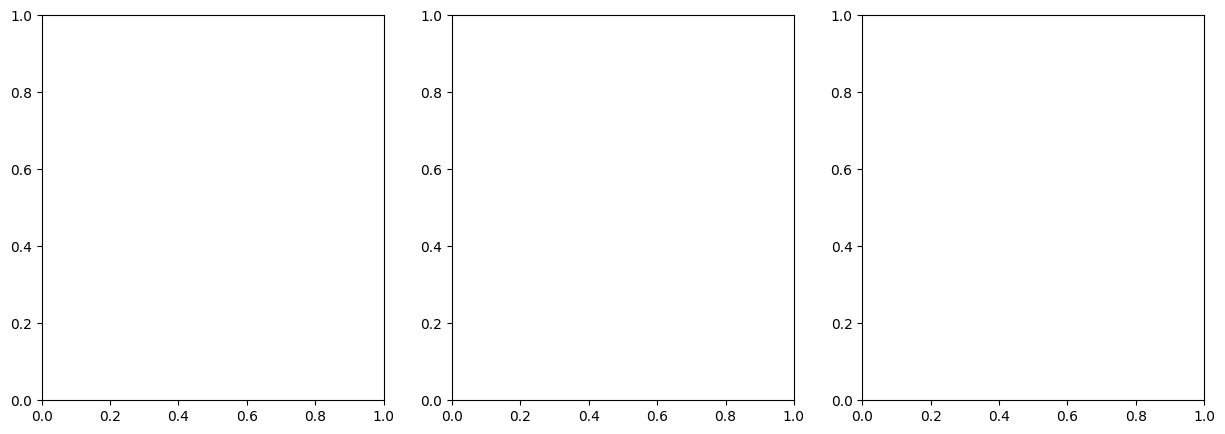

In [259]:
# Sample data
x = np.linspace(0, 10, 100)
y1 = df_knn["MAE"]
y2 = df_knn["CV_MAE"]
y3 = df_knn["R_2"]

# Creating subplots with shared y-axis
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plotting data on each subplot
ax1.bar(df_list, y1)
ax2.bar(df_list, y2)
ax3.bar(df_list, y3)

# Setting titles for subplots
ax1.set_title("Sin(x)")
ax2.set_title("Cos(x)")
ax3.set_title("Tan(x)")

# Adding a common ylabel
fig.text(0.5, 0.04, "x", ha="center", va="center")
fig.text(0.06, 0.5, "y", ha="center", va="center", rotation="vertical")

plt.show()

In [243]:
fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, figsize=(12, 4), sharey=True, constrained_layout=True, wspace=0.3
)

data_list = ["df1", "df2", "df3", "df4", "df5", "df6"]

# Assume df_knn is defined somewhere in your code
ax1.bar(data_list, height=df_knn["MAE"])
ax2.bar(data_list, height=df_knn["R_2"])
ax3.bar(data_list, height=df_knn["CV_MAE"])

ax1.set_title("MAE Scores")
ax2.set_title("R_2 Scores")
ax3.set_title("CV_MAE Scores")

plt.show()

AttributeError: Figure.set() got an unexpected keyword argument 'wspace'

In [ ]:
# # One Hot Encoder
# # Apply one-hot encoder to each column with categorical data
# OHE = OneHotEncoder(handle_unknown="ignore", sparse=False)
# OH_cols_train = pd.DataFrame(OHE.fit_transform(X_train_imputed[cat_cols]))
# OH_cols_valid = pd.DataFrame(OHE.transform(X_test_imputed[cat_cols]))

# # One-hot encoding removed index; put it back
# OH_cols_train.index = X_train_imputed.index
# OH_cols_valid.index = X_test_imputed.index

# # Remove categorical columns (will replace with one-hot encoding)
# num_X_train_imputed = X_train_imputed.drop(cat_cols, axis=1)
# num_X_test_imputed = X_test_imputed.drop(cat_cols, axis=1)

# # Add one-hot encoded columns to numerical features
# OH_X_train_imputed = pd.concat([num_X_train_imputed, OH_cols_train], axis=1)
# OH_X_test_imputed = pd.concat([num_X_test_imputed, OH_cols_valid], axis=1)

# # Ensure all columns have string type
# OH_X_train_imputed.columns = OH_X_train_imputed.columns.astype(str)
# OH_X_test_imputed.columns = OH_X_test_imputed.columns.astype(str)

# # print("MAE from Approach 3 (One-Hot Encoding):")
# # print(score_dataset(OH_X_train_imputed, OH_X_test_imputed, y_train, y_valid))

In [ ]:
# OH_X_train_imputed.head(15)
# OH_X_train_imputed.rename(
#     columns={
#         "0": "cyl_3",
#         "1": "cyl_4",
#         "2": "cyl_5",
#         "3": "cyl_6",
#         "4": "cyl_8",
#         "5": "org_1",
#         "6": "org_2",
#         "7": "org_3"},
#     inplace=True,
# )